In [4]:
import tensorflow as tf
import numpy as np
print(tf.__version__)

2.7.0


In [5]:
import tensorflow_datasets as tfds

imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

2021-11-30 12:34:45.385504: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
train_data, test_data = imdb["train"], imdb["test"]

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s, l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())

for s, l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [7]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = "post"
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create a tokenizer
tokenizer = Tokenizer(
    num_words=vocab_size,
    oov_token=oov_tok,
)

# Fit the tokenizer on the training sentences
tokenizer.fit_on_texts(training_sentences)

# Create a word_index
word_index = tokenizer.word_index

# Convert the training and test sentences into sequences of word indexes
sequences = tokenizer.texts_to_sequences(training_sentences)

# Pad the sequences
padded = pad_sequences(sequences, maxlen=max_length, padding=trunc_type)


# Create sequences for the testing data
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
# Pad the testing data
padded_testing = pad_sequences(testing_sequences, maxlen=max_length, padding=trunc_type)


In [8]:
# Train the embedding

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  # tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(6, activation="relu"),
  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Fit the model
num_epochs = 10

history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(padded_testing, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 3s 4ms/step - loss: 0.4598 - accuracy: 0.7662 - val_loss: 0.3470 - val_accuracy: 0.8460
Epoch 2/10
782/782 [==============================] - 2s 3ms/step - loss: 0.2000 - accuracy: 0.9252 - val_loss: 0.3468 - val_accuracy: 0.8528
Epoch 3/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0661 - accuracy: 0.9856 - val_loss: 0.4282 - val_accuracy: 0.8414
Epoch 4/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0168 - accuracy: 0.9984 - val_loss: 0.4968 - val_accuracy: 0.8423
Epoch 5/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0054 - accuracy: 0.9996 - val_loss: 0.5463 - val_accuracy: 0.8401
Epoch 6/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.5976 - val_accuracy: 0.8404
Epoch 7/10
782/782 [==============================] - 2s 2ms/step - loss: 7.5772e-04 - accuracy: 1.0000 - val_loss: 0.6312 - val_accuracy: 0.8424
Ep

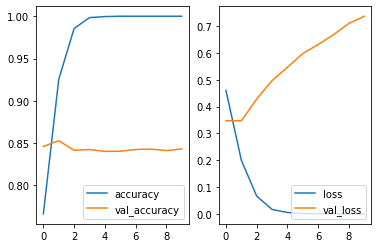

In [10]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label='val_accuracy')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend(loc='lower right')
plt.show()


In [11]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) #shape: (vocab_size, embedding_dim)

(10000, 16)


In [12]:
import io

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(padded[3])
print(decode_review(padded[3]))
print(training_sentences[3])

[ 360    7    2  239    5   20   16    4 8837 2705 2679   55    2  367
    5    2  179   58  141 1419   17   94  203  980   15   23    1   86
    4  193 3134 3069    3    1   16    4  383    5  640  395  361   38
 5863    3 5741 1859   15  208 8659 3471    2  115  376   44   25   61
    1    6 1681   61 1846 4127   43    4 2289    3 1963    1  145  159
  784  113   32   94  120    4  215   20    9  175  282    3   30   13
 1027    2 2846   10 2020   47    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
b'this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family f

In [13]:
import os

data_path = "../data/"
os.makedirs(os.path.join(data_path, "C3-ImdbReviewsSentiment/"))
out_v_path = os.path.join(data_path, "C3-ImdbReviewsSentiment/vecs.tsv")
out_m_path = os.path.join(data_path, "C3-ImdbReviewsSentiment/meta.tsv")

out_v = io.open(out_v_path, 'w', encoding='utf-8')
out_m = io.open(out_m_path, 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()

# View these files in https://projector.tensorflow.org/

FileExistsError: [Errno 17] File exists: '../data/C3-ImdbReviewsSentiment/'

In [20]:
def predict_sentiment(sentence, model):
    # Add the padding
    sentence = [[word_index[word.lower()] for word in sentence.split()] for sentence in sentences]
    padded = pad_sequences(sentence, maxlen=max_length, padding=trunc_type)
    print(padded)

    # Perform the prediction
    p = model.predict(padded)

    # Round to the nearest integer
    p = tf.round(p)
    print(p.numpy())
    return p

sentences = ["I hated this movie the actors played so badly", "This movie was amazing and I will watch it again"]
predict_sentiment(sentences, model)


[[  11 1822   12   18    2  156  255   37  921    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  12   18   14  491    3   11   81  107   10  172    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.],
       [1.]], dtype=float32)>